In [31]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyval2d
from numpy.polynomial.chebyshev import chebval2d
from scipy.stats import multivariate_normal
import scipy.signal

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import linear_model

In [44]:
def compute_xy_grids(x_len, y_len):
    x = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
    y = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)
    xx, yy = np.meshgrid(x, y)
    return xx, yy
    
def gaussian2d(xx, yy, m=[0., 0.], cov=[[1, 0], [0, 1]]):
    grid = np.dstack((xx, yy))
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

def sim_source_catalog(n_sources, x_lim, y_lim, min_flux, max_flux, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    x_pos = np.random.uniform(x_lim[0], x_lim[1], n_sources)
    y_pos = np.random.uniform(y_lim[0], y_lim[1], n_sources)  
    fluxes = np.random.uniform(min_flux, max_flux, n_sources)
    source_catalog = {'x_pos': x_pos, 'y_pos': y_pos, 'fluxes': fluxes}
    return source_catalog

def sim_image(image_size, sky_sig, psf_sig, source_catalog, random_seed=None):
    image_xx, image_yy = compute_xy_grids(image_size, image_size)
    image_grid = np.dstack((image_xx, image_yy))
    image =  np.random.normal(scale=sky_sig, size=(image_size, image_size))
    # add background sources
    fluxes = source_catalog['fluxes']
    x_pos, y_pos = source_catalog['x_pos'], source_catalog['y_pos']
    if random_seed is not None:
        print('Turning on patial variation')
        np.random.seed(random_seed)
        x_pos = x_pos + np.random.uniform(-0.1, 0.1, len(x_pos))
    for i in range(len(fluxes)):
        image += fluxes[i] * gaussian2d(
            image_xx, image_yy, m=[x_pos[i], y_pos[i]], cov=[[psf_sig, 0], [0, psf_sig]]
        )
    return image


def chebGauss2d(xx, yy, gauss_cov, poly_deg):
    # compute Gaussian
    gau = gaussian2d(xx, yy, cov=gauss_cov)
    # compute Chebyshev
    x_deg, y_deg = poly_deg[0], poly_deg[1]
    coef_x = np.zeros(x_deg + 1)
    coef_x[x_deg] = 1
    coef_y = np.zeros(y_deg + 1)
    coef_y[y_deg] = 1
    coefs = np.outer(coef_x, coef_y)
    cheb = chebval2d(xx, yy, c=coefs)
    return cheb * gau

def compute_kernel_bases(kernel_size, sig_ls, poly_deg_ls):
    xx, yy = compute_xy_grids(kernel_size, kernel_size)
    kernel_bases = []
    for id_x, x_sig in enumerate(sig_ls):
        for id_y, y_sig in enumerate(sig_ls):
            for x_deg in range(poly_deg_ls[id_x]+1):
                for y_deg in range(poly_deg_ls[id_y]+1):
                    gauss_cov = [[x_sig, 0.], [0., y_sig]]
                    poly_deg = (x_deg, y_deg)
                    kernel_bases.append(chebGauss2d(xx, yy, gauss_cov, poly_deg))   
    return kernel_bases

def compute_base_image_matrix(template, kernel_bases):
    base_im_ls = []
    for basis in kernel_bases:
        base_im = scipy.signal.fftconvolve(template, basis, mode='same')
        base_im_ls.append(base_im.flatten())
    base_image_matrix = np.vstack(base_im_ls).T   
    return base_image_matrix

def compute_spatial_image_matrix(xx, yy, spatial_deg, verbose=False):
    spatial_image_ls = []
    for x_deg in range(spatial_deg + 1):
        for y_deg in range(spatial_deg - x_deg + 1):
            if verbose:
                print(x_deg, y_deg)
            coef_x = np.zeros(x_deg + 1)
            coef_x[x_deg] = 1
            coef_y = np.zeros(y_deg + 1)
            coef_y[y_deg] = 1
            coefs = np.outer(coef_x, coef_y)
            spatial_image = polyval2d(xx, yy, c=coefs)
            spatial_image_ls.append(spatial_image.flatten())
    spatial_image_matrix = np.vstack(spatial_image_ls).T
    return spatial_image_matrix


def compute_base_spatial_image_matrix(base_image_matrix, kernel_spatial_image_matrix):
    base_spatial_vec_ls = []
    for i in range(base_image_matrix.shape[1]):
        base_vec = base_image_matrix[:, i]
        for j in range(kernel_spatial_image_matrix.shape[1]):
            kernel_spatial_vec = kernel_spatial_image_matrix[:, j]
            base_spatial_vec = base_vec * kernel_spatial_vec
            base_spatial_vec_ls.append(base_spatial_vec)
    base_spatial_image_matrix = np.vstack(base_spatial_vec_ls).T
    return base_spatial_image_matrix

def compute_X(template, kernel_size, gauss_sig_ls, poly_deg_ls,
              kernel_spatial_deg, background_spatial_deg):
    # spatial expansion
    Nx, Ny = template.shape[1], template.shape[0]
    image_xx, image_yy = compute_xy_grids(Nx, Ny)
    xx_norm, yy_norm = image_xx / Nx, image_yy / Ny
    # compute base image matrix
    kernel_bases = compute_kernel_bases(kernel_size, gauss_sig_ls, poly_deg_ls)
    base_image_matrix = compute_base_image_matrix(template, kernel_bases)
    # compuate spatial image matrix
    kernel_spatial_image_matrix = compute_spatial_image_matrix(xx_norm, yy_norm, kernel_spatial_deg, verbose=False)
    background_spatial_image_matrix = compute_spatial_image_matrix(xx_norm, yy_norm, background_spatial_deg, verbose=False)
    # compute base spatial image matrix
    base_spatial_image_matrix = compute_base_spatial_image_matrix(
        base_image_matrix, kernel_spatial_image_matrix)
    # compute X
    X = np.concatenate((base_spatial_image_matrix, background_spatial_image_matrix), axis=1)
    return X

In [52]:
image_size = 255
# simulate source catalog
n_background_sources = 20
# image size
edge_offset = 10
x_lim = (- image_size//2 + 1 + edge_offset, image_size//2 + 1 - edge_offset)
y_lim = (- image_size//2 + 1 + edge_offset, image_size//2 + 1 - edge_offset)
# fluxes
min_flux, max_flux = 20000, 50000
# background source
background_src_cat = sim_source_catalog(
    n_background_sources, x_lim,  y_lim, min_flux, max_flux, random_seed=1
)
# image sigma
tmpl_sky_sig, sci_sky_sig = 0.2, 0.2
tmpl_psf_sig, sci_psf_sig = 1.6, 2.2
# simulate images
tmpl = sim_image(image_size, tmpl_sky_sig, tmpl_psf_sig, background_src_cat)
sci = sim_image(image_size, sci_sky_sig, sci_psf_sig, background_src_cat)
sci_vec = sci.flatten()
sci_spatial = sim_image(image_size, sci_sky_sig, sci_psf_sig, background_src_cat, random_seed=0)
sci_spatial_vec = sci_spatial.flatten()

Turning on patial variation


In [53]:
# kernel parameters
gauss_sig_ls = [0.75, 1.5, 3.0]
poly_deg_ls = [4, 2, 2]
kernel_size = 31
# spatial degree of freedom
kernel_spatial_deg = 2
background_spatial_deg = 1

In [54]:
X = compute_X(tmpl, kernel_size, gauss_sig_ls, poly_deg_ls,
              kernel_spatial_deg, background_spatial_deg)

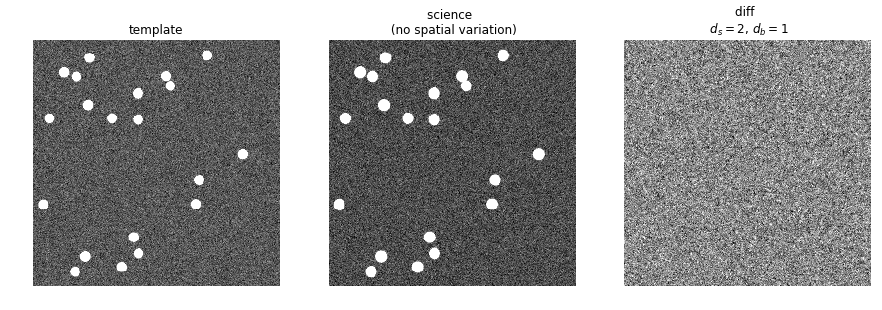

In [55]:
lin = linear_model.LinearRegression()
lin.fit(X, sci_vec)

sci_pred = lin.predict(X)
diff = sci - sci_pred.reshape(tmpl.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
title_ls = ['template', 'science \n (no spatial variation)',
            'diff \n $d_s=2$, $d_b=1$']
ax[0].imshow(interval(tmpl), cmap='gray', origin='lower')
ax[1].imshow(interval(sci), cmap='gray', origin='lower')
ax[2].imshow(interval(diff), cmap='gray', origin='lower')
for i in range(3): ax[i].set_axis_off() 
for i in range(3): ax[i].set_title(title_ls[i]) 

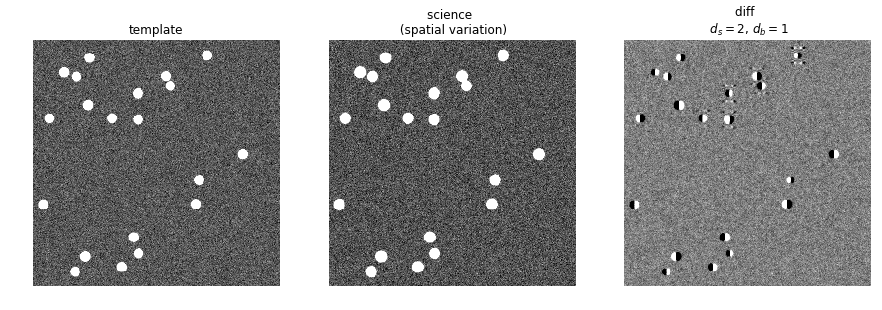

In [58]:
lin = linear_model.LinearRegression()
lin.fit(X, sci_spatial_vec)

sci_pred = lin.predict(X)
diff = sci_spatial - sci_pred.reshape(tmpl.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
title_ls = ['template', 'science \n (spatial variation)',
            'diff \n $d_s=2$, $d_b=1$']
ax[0].imshow(interval(tmpl), cmap='gray', origin='lower')
ax[1].imshow(interval(sci_spatial), cmap='gray', origin='lower')
ax[2].imshow(interval(diff), cmap='gray', origin='lower')
for i in range(3): ax[i].set_axis_off() 
for i in range(3): ax[i].set_title(title_ls[i]) 

### Spatial Degree of Freedom.

In [125]:
# kernel parameters
gauss_sig_ls = [0.75, 1.5, 3.0]
poly_deg_ls = [4, 2, 2]
kernel_size = 31
# spatial degree of freedom
kernel_spatial_deg_ls = [2, 3, 4, 5]
background_spatial_deg = 1

y = sci_spatial_vec
im_shape = tmpl.shape

In [126]:
X_ls = []
for kernel_spatial_deg in kernel_spatial_deg_ls:
    X = compute_X(tmpl, kernel_size, gauss_sig_ls, poly_deg_ls,
              kernel_spatial_deg, background_spatial_deg)
    X_ls.append(X)
    
lin_ls = []
for X in X_ls:
    lin = linear_model.LinearRegression(fit_intercept=False)
    lin.fit(X, y)
    lin_ls.append(lin)

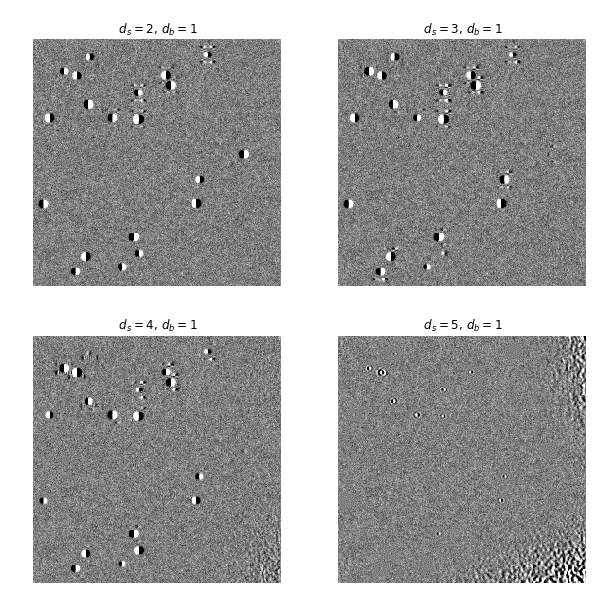

In [137]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.flat
for i in range(4):
    X = X_ls[i]
    lin = lin_ls[i]
    y_pred = lin.predict(X)
    diff = (y - y_pred).reshape(im_shape)
    ax[i].imshow(interval(diff), cmap='gray', origin='lower')
    ax[i].set_title(f'\n $d_s={i+2}$, $d_b=1$')
    ax[i].set_axis_off()

### Ridge regression (L2 regularization)

$L = (\vec{y} - X\vec{\theta})^T(\vec{y} - X\vec{\theta}) + 
\alpha \cdot \vec{\theta}^T\vec{\theta}$

In [128]:
kernel_spatial_deg = 5
X5 = compute_X(tmpl, kernel_size, gauss_sig_ls, poly_deg_ls,
              kernel_spatial_deg, background_spatial_deg)

In [129]:
alpha_ls = [1, 0.1, 0.01, 0.001]
ridge_ls = []
for a in alpha_ls:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X5, y)
    ridge_ls.append(ridge)

/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.17499e-17): result may not be accurate.
  overwrite_a=True).T


Text(0.5, 0.98, 'L2 Regularization')

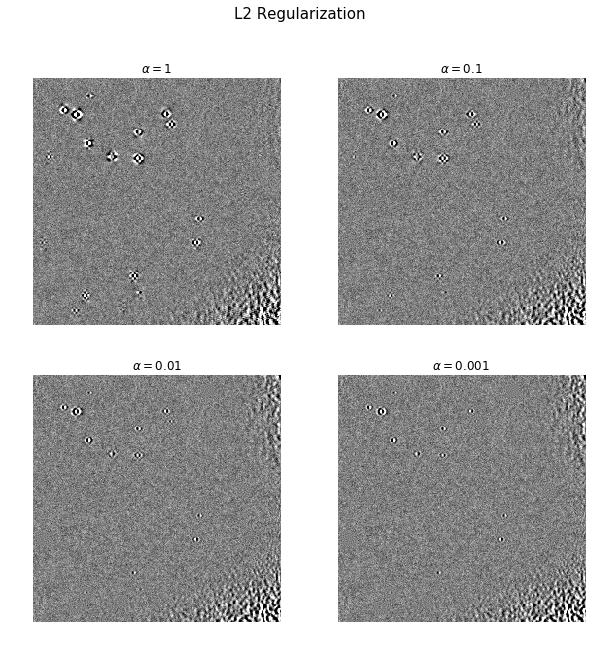

In [130]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.flat
for i in range(4):
    a = alpha_ls[i]
    ridge = ridge_ls[i]
    y_pred = ridge.predict(X5)
    diff = (y - y_pred).reshape(im_shape)
    ax[i].imshow(interval(diff), cmap='gray', origin='lower')
    ax[i].set_title(f'$\\alpha={a}$')
    ax[i].set_axis_off()
plt.suptitle('L2 Regularization', size=15)

#### Linear vs. Ridge

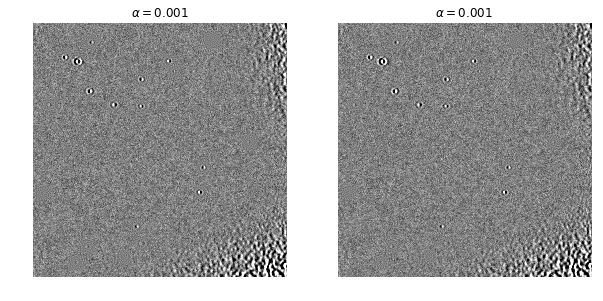

In [138]:
lin_diff = (y - lin_ls[3].predict(X5)).reshape(im_shape)
ridge_diff = (y - ridge_ls[3].predict(X5)).reshape(im_shape)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(interval(lin_diff), cmap='gray', origin='lower')
ax[0].set_title(f'$\\alpha=0.001$')
ax[0].set_axis_off()
ax[1].imshow(interval(ridge_diff), cmap='gray', origin='lower')
ax[1].set_title(f'$\\alpha=0.001$')
ax[1].set_axis_off()

In [153]:
lin_diff.sum(), ridge_diff.sum()

(0.285334261909302, -6.647280059723926e-09)

In [155]:
lin_diff.max(), ridge_diff.max()

(8.713166046517586, 9.068894194735776)

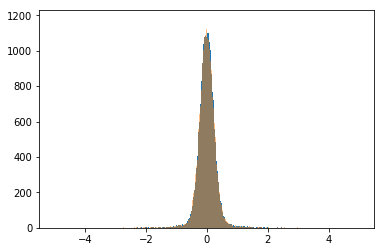

In [156]:
bins = np.linspace(-5.,5.,1000)
plt.hist(lin_diff.flatten(),bins=bins);
plt.hist(ridge_diff.flatten(), alpha=0.5, bins=bins);

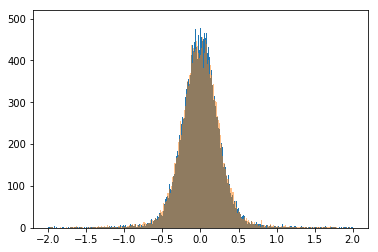

In [152]:
bins = np.linspace(-2.,2.,1000)
plt.hist(lin_diff.flatten(),bins=bins);
plt.hist(ridge_diff.flatten(), alpha=0.5, bins=bins);

Text(0, 0.5, 'fitting parameter value')

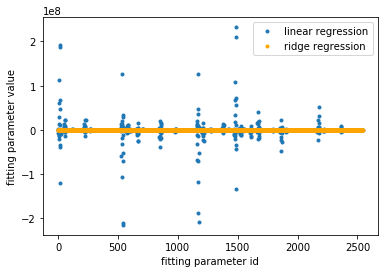

In [135]:
plt.plot(lin_ls[3].coef_, '.',label='linear regression')
plt.plot(ridge_ls[3].coef_, '.', color='orange', label='ridge regression')
plt.legend()
plt.xlabel('fitting parameter id')
plt.ylabel('fitting parameter value')
# plt.ylim((-1,1))

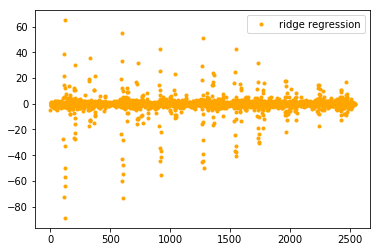

In [136]:
plt.plot(ridge_ls[3].coef_, '.', color='orange', label='ridge regression')
plt.legend()

Linear regression fits parameters with extreme values. Ridge regression does not.